Este programa clasifica mariposas usando CNN
El dataset de mariposas viene de: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification/data

Damariz Licea A01369045

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, RandomFlip, RandomRotation, RandomZoom
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "/content/drive/MyDrive/tc3002/mairposas"

/content/drive/MyDrive/tc3002/mairposas


Este código fue elaborado en Google Colab, por lo tanto el ruteo no corresponde a las carpetas del repositorio.

In [4]:
# Directorios y rutas base
base_dir = '/content/drive/MyDrive/tc3002/mairposas'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
#Existe el CSV de testing pero no trae nada
train_labels_path = os.path.join(base_dir, 'Training_set.csv')

# Manejo de CSV y labels
# Las labels pasan a ser indices
df = pd.read_csv(train_labels_path)
df['filepaths'] = df['filename'].apply(lambda x: os.path.join(train_dir, x))
label_to_index = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label_idx'] = df['label'].map(label_to_index)

# Separar 80% para training y 20% para testing
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label_idx'], random_state=42)
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# De dataframe a dataset
def df_to_dataset(dataframe, shuffle=True):
    path_ds = tf.data.Dataset.from_tensor_slices(dataframe['filepaths'].values)
    label_ds = tf.data.Dataset.from_tensor_slices(dataframe['label_idx'].values)
    img_ds = path_ds.map(lambda x: tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(x), channels=3), IMG_SIZE)/255.0)
    ds = tf.data.Dataset.zip((img_ds, label_ds))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = df_to_dataset(train_df)
test_ds = df_to_dataset(test_df, shuffle=False)

In [5]:
# Aumentación: Volteo horizontal, rotación y zoom
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

In [6]:
# CNN
# 2 capas convolucionales, 2 capas de pooling, 1 capa densa
model = Sequential([
    data_augmentation,
    Conv2D(32, 3, activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(label_to_index), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
history = model.fit(train_ds, validation_data=test_ds, epochs=10)
model.save('modelo_mariposas.keras')

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1018s 2s/step - accuracy: 0.0417 - loss: 4.3410 - val_accuracy: 0.1638 - val_loss: 3.3178
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.2350 - loss: 3.0033 - val_accuracy: 0.3546 - val_loss: 2.5728
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 180s 987ms/step - accuracy: 0.3724 - loss: 2.3534 - val_accuracy: 0.4115 - val_loss: 2.3544
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.4760 - loss: 1.9462 - val_accuracy: 0.4492 - val_loss: 2.2918
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.5349 - loss: 1.6831 - val_accuracy: 0.4746 - val_loss: 2.1202
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.5828 - loss: 1.4699 - val_accuracy: 0.5077 - val_loss: 2.0184
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 192s 966ms/step - accuracy: 0.6090 - loss: 1.4047 - val_accuracy: 0.5277 - val_loss: 1.8855
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 192s 907ms/step - accuracy: 0.6478 - loss: 1.2263 

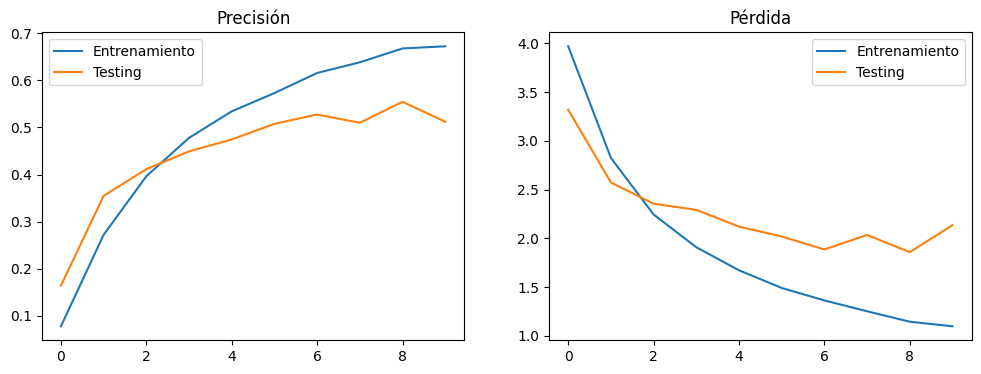

In [12]:
# Desempeño: Accuracy y Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Testing')
plt.title('Precisión')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Testing')
plt.title('Pérdida')
plt.legend()
plt.show()


Imagen: Image_2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Predicción: ADONIS (99.90%)


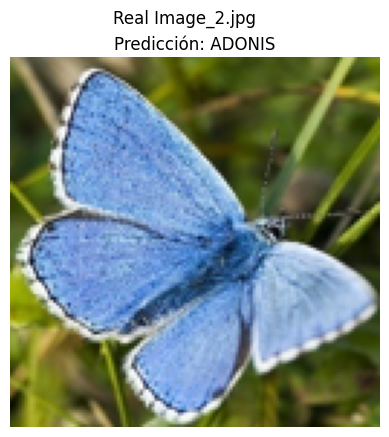

Imagen: Image_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicción: GREAT EGGFLY (50.68%)


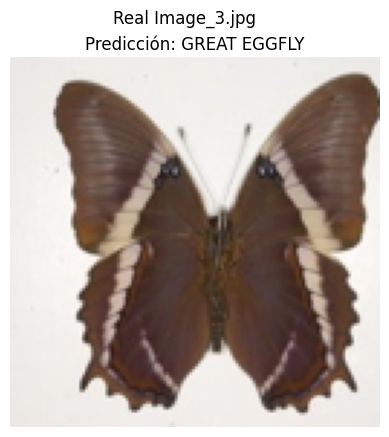

In [9]:
# Función para ver visualmente qué hace el modelo
# ahorita solo pone una imagen fija que le das, que es la 2

def predict_image(img_path):
    img = Image.open(img_path).resize(IMG_SIZE)
    real_name = img_path.split('/')[-1]
    print(f"Imagen: {real_name}")
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # (1, 128, 128, 3)
    pred = model.predict(img_array)[0]
    pred_class = np.argmax(pred)
    confidence = pred[pred_class]

    for label, idx in label_to_index.items():
        if idx == pred_class:
            print(f"Predicción: {label} ({confidence*100:.2f}%)")
            break

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicción: {label}")
    plt.suptitle(f"Real {real_name} ")
    plt.show()

predict_image(df.iloc[1]['filepaths'])
predict_image(df.iloc[2]['filepaths'])
